## Time series forecasting in TensorFlow (BitPredict)
We will predict the cost of Bitcoin tomorrow for practicing timeseries data

Note: This is not financial advice! Time series forecasting for stock market price is actually terrible.\

## Types of Time series
<b>Trend</b> -> time series has a clear long-term increase or decrease\

<b>Seasonal</b> -> time series affected by seasonal factors such as time of year\

<b>Cyclic</b> -> time series shows rises and falls over an unfixed period

In [1]:
filepath = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"

## Import time series data with Pandas

In [2]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv(filepath, 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
# We only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={'Closing Price (USD)': "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Let's plot everything of the closing day price of bitcoin!

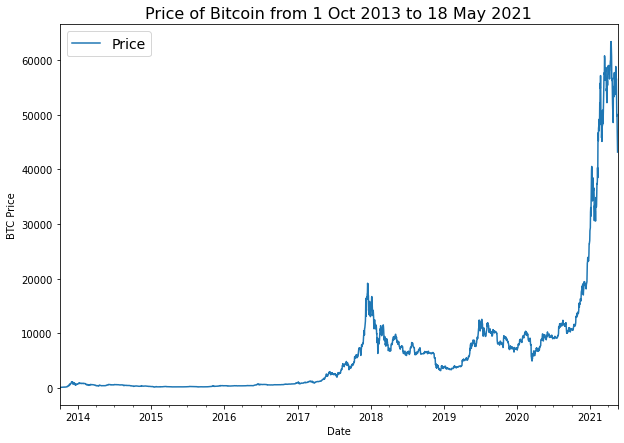

In [5]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

Dang it, If I bought bitcoin at 2014, I will be rich :)

## Train_test_split Time series data

Before splitting, it is important to know what type of time-series data we have here?\
<b>Univariate</b> time series data deals with one variable. For ex, using price of bitcoin to predict bitcoin\
<b>Multivariate</b> time series data deals with more than one variable. For ex, predict energy demand using day of week, time of year and number of houses.\

How do we split?\
Unlike regular splitting, test data now is the data from future and train data is the data from the past. We will pick a point in time and separate sequence data into past and future.

In [6]:
# Get bitcoin date array
prices = bitcoin_prices['Price'].to_numpy()
timesteps = bitcoin_prices.index.to_numpy()

# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)


(2229, 558, 2229, 558)

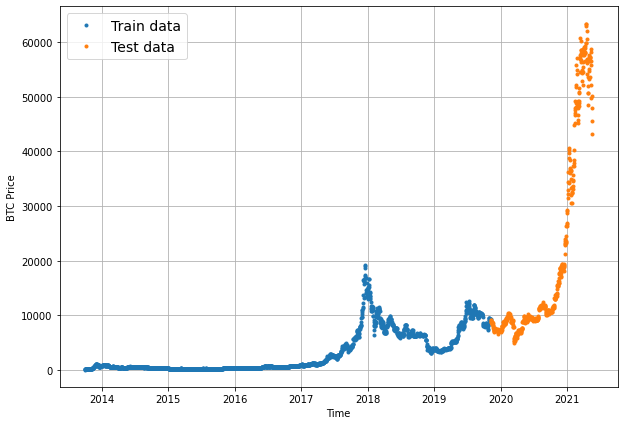

In [9]:
# Create a plot function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    """
    timesteps: array of timesteps
    values: array of values across time
    format: style of plot, default
    start: where to start the plot
    end: where to end the plot
    label: label to show on plot of values"""

    # plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)

# Try out our plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

# Modelling experiments
Before discuss what modelling experiments going to run, these are two terms we should know.\
<b>Horizon -> </b> number of timesteps to predict into future\
<b>Window -> </b> number of timesteps from past used to predict horizon\
1 day in future -> horizon = 1\
7 days in past -> window = 7

Model 0: Naiive forecast (baseline)
All naiive model is used the previous timestep value to predict the next timestep value\

Formula will be like\
$$\hat{y_t} = y_{t-1}$$

In an open system (like stock market or crypto market), you'll find beating the naiive forecast with any kind of model is quite hard.\

<b>Open system</b> is a system where inputs and outputs can freely flow, such as a market(stock or crypto). Time series forecasting in open systems in generally quite poor.

In [10]:
# Create a naiive forecast
naive_forecast = y_test[:-1] # naiive forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # view first 10 and last 10



(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

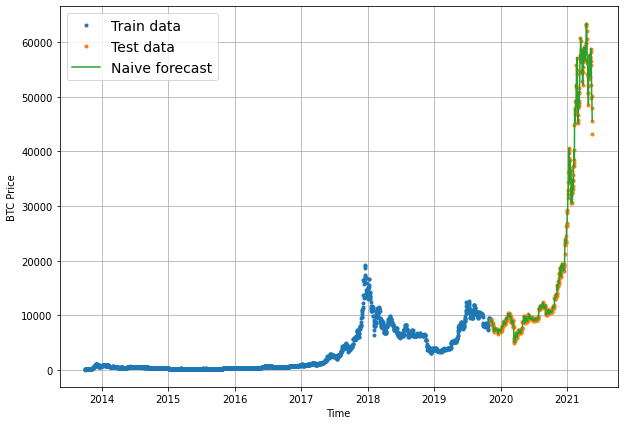

In [11]:
# Plot naiive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast")

Let's zoom in to take a better look

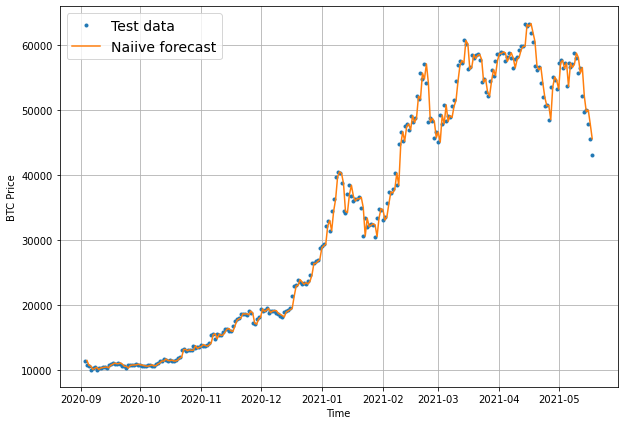

In [12]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naiive forecast")

# Evaluate time series model
There are many metrics.... We will use MAE as good place to start.


In [13]:
import tensorflow as tf

#Created our own Mean aboslute scaled error.
def mean_absolute_scaled_error(y_true, y_pred):
    """MASE (assuming no seasonality of data).
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

    return mae / mae_naive_no_season

In [14]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [15]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

Each prediction in naive forecast is on average off by $567

In [16]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737222

average price of Bitcoin in the test dataset is $20,056

## Windowing dataset
Before building models, we need to window our time series to make into supervised learning problem. Because our window = 7 and horizon = 1, an example will look like this.\
[0,1,2,3,4,5,6] -> [7]

In [18]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [19]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
    """Create labels for windowed datasets."""

    return x[:, :-horizon], x[:, -horizon:]

In [20]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [23]:
import numpy as np
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [24]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

## Turning windows into training and test sets


In [25]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [26]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [27]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

## Model 1: Simple Dense Model (window = 7, horizon = 1)

In [29]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear") # linear activation same as no activation
], name="model_1_dense")

# Compile model
model_1.compile(loss="mae",
optimizer=tf.keras.optimizers.Adam(),
metrics=["mae"])

# Fit model
model_1.fit(x=train_windows,
y=train_labels,
epochs=100,
verbose=1,
batch_size=128,
validation_data=(test_windows, test_labels))

Epoch 1/100
18/18 [==============================] - 2s 10ms/step - loss: 780.3595 - mae: 780.3595 - val_loss: 2278.5544 - val_mae: 2278.5544
Epoch 2/100
18/18 [==============================] - 0s 2ms/step - loss: 247.8195 - mae: 247.8195 - val_loss: 1008.0859 - val_mae: 1008.0859
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 190.4361 - mae: 190.4361 - val_loss: 958.1794 - val_mae: 958.1794
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 172.5639 - mae: 172.5639 - val_loss: 901.7570 - val_mae: 901.7570
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 163.4465 - mae: 163.4465 - val_loss: 874.2380 - val_mae: 874.2380
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 159.9092 - mae: 159.9092 - val_loss: 848.6147 - val_mae: 848.6147
Epoch 7/100
18/18 [==============================] - 0s 2ms/step - loss: 151.7330 - mae: 151.7330 - val_loss: 832.2957 - val_mae: 832.2957
Epoch 8/100
18/18 [===

In [30]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 680.8662 - mae: 680.8662


[680.8662109375, 680.8662109375]

# Make forecasts with a model (on the test dataset)


In [32]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [33]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8684.65 , 8601.365, 8862.704, 8638.989, 8566.2  , 8578.227,
        8530.663, 8339.662, 8313.019, 8363.438], dtype=float32)>)

In [34]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 680.8662,
 'mse': 1408195.2,
 'rmse': 1186.6741,
 'mape': 3.1296875,
 'mase': 1.1960933}

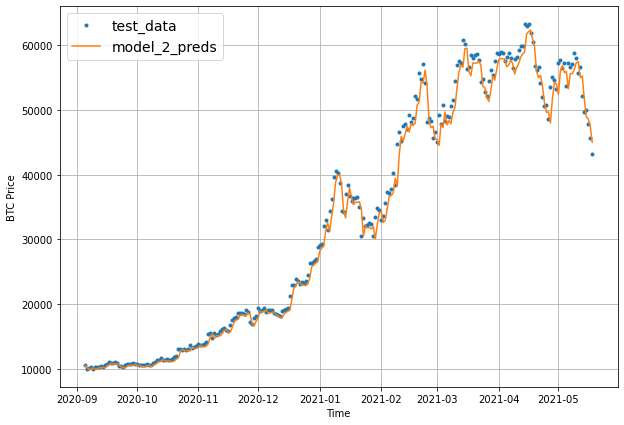

In [36]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_2_preds")

## Model 2: Train a model on the full historical data to make predictions into future

It's time we created a model which able to make future predictions on the price of Bitcoin (actual future)

Forecasting models need to be retrained every time a forecast is made. Why? Because if Bitcoin prices are updated daily and you predict the price for tomorrow. Your model is only really valid for one day. When a new price comes out (e.g. the next day), you'll have to retrain your model to incorporate that new price to predict the next forecast.

In [52]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [53]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [54]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None
# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()


,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [56]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [57]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [58]:
# Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [59]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

In [60]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before

In [61]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

In [62]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [63]:
# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts 
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55817.91796875

Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55817.91796875] -> Prediction: 51045.94921875

Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55817.91796875 51045.94921875] -> Prediction: 48894.76953125

Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55817.91796875 51045.94921875 48894.76953125] -> Prediction: 48322.51953125

Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55817.91796875
 51045.94921875 48894.76953125 48322.51953125] -> Prediction: 47821.6015625

Predicting on: 
 [45604.61575361 43144.47129086 55817.91796875 51045.94921875
 48894.76953125 48322.51953125 47821.6015625 ] -> Prediction: 46980.421875

Predicting on: 
 [43144.47129086 55817.91796875 51045.94921875 4889

In [64]:
future_forecast[:10]

[55817.918,
 51045.95,
 48894.77,
 48322.52,
 47821.6,
 46980.42,
 48484.84,
 54123.492,
 49909.273,
 48031.758]

In [65]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end d

In [68]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [69]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

More details and reference from here (on how to predict actual future on time series data)
https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb